<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration9_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 인물 모드 문제점 찾기

일단 필요한 라이브러리를 불러오겠습니다. 코랩에서 실습하려니 라이브러리 버전이 맞지 않아서 필요한 패키지를 새로 설치하였습니다.

In [1]:
#!pip3 install pixellib

In [2]:
#!pip install tensorflow==1.15

In [3]:
#!pip install 'h5py<3.0.0'

In [4]:
import importlib_metadata as metadata
import cv2
import os
import pixellib
import numpy as np
import urllib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print(cv2.__version__)
print(metadata.version('pixellib'))

4.6.0
0.7.1


## 1. 셀카 아웃포커싱 해보기  
먼저 노드에서 배운대로 셀카를 이용해서 아웃포커싱을 해보겠습니다.  
일단 사진을 불러옵니다.

(1440, 1080, 3)


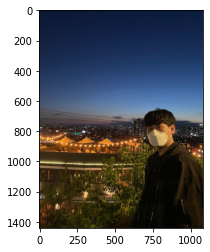

In [5]:
img_path = '/content/drive/MyDrive/Colab/Datasets/segmentation/1.jpg'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

이제 배경을 분리해줄 세그멘테이션 모델을 불러옵니다. 사용할 모델은 DeepLab v3+ 입니다.  
아까 설치한 PixelLib를 여기서 사용합니다.

In [6]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/Colab/Datasets/segmentation/models/'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/Colab/Datasets/segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ffa0f08f690>)

In [7]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


이제 불러온 모델을 통해 세그멘테이션을 해줍니다.

In [8]:
segvalues, output = model.segmentAsPascalvoc(img_path)

위에서 모델의 segmentAsPascalvoc 함수로 분류를 해줬는데 PASCAL VOC는 21개의 클래스를 가집니다. 

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

output에는 세그멘테이션 결과 이미지가, segvalues에는 class_ids와 masks가 저장됩니다. 

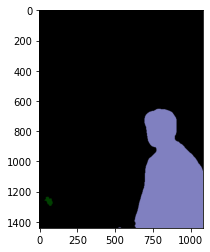

In [10]:
plt.imshow(output)
plt.show()

In [11]:
segvalues

{'class_ids': array([ 0, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

배경과 제 모습 그리고 왼쪽에 초록색 점이 작게 찍혀있는데 뭔지 모르겠네요.  
segvalues의 class_ids로 뭔지 확인해 봅시다.

In [12]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


배경에 있는 나무중 극히 일부를 화분으로 인식한 것 같습니다.  
이제 사람 부분을 추출하기 위해 무슨 색상으로 output에 나타냈는지 확인해 봅시다.

In [13]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

15번째가 사람을 나타냅니다.

In [14]:
print(LABEL_NAMES[15])
print(colormap[15])

person
[192 128 128]


여기서 output 이미지는 BGR이기 때문에 RGB로 순서를 바꾸어서 seg_color를 지정해 주고, 해당 컬러 부분만 흰색으로 표시하도록 합니다.

(1440, 1080)


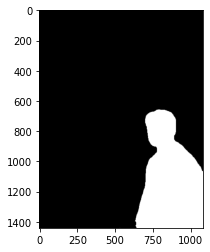

In [15]:
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

이제 세그멘테이션 결과를 원본 이미지에 겹쳐서 분류가 제대로 됐는지 확인해 봅시다.

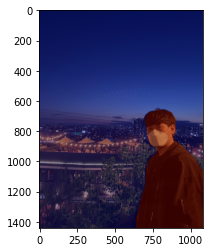

In [16]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

제 모습과 배경이 다른 색상으로 표현된 것을 확인할 수 있습니다.  
이제 아웃포커싱을 위해 배경을 흐리게 만들어 주는 작업을 합니다.  
일단 사진 전체를 blur처리한 이미지를 생성합니다.

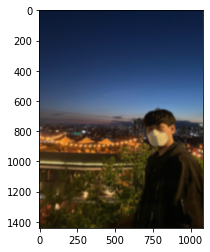

In [17]:
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

이제 blur처리된 배경만 뽑습니다.  
bitwise_not은 이미지를 반전시킵니다. 0과 255가 교체되어 사람은 0 배경이 255가 됩니다.  
bitwise_and는 mask 영역에서 서로 공통으로 겹치는 부분을 출력합니다. bitwise_not 연산으로 배경이 255가 되었으니 배경 부분만 출력됩니다.

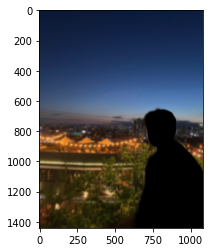

In [18]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

이제 np.where를 사용해 그림을 합쳐줍니다. 첫번째 파라미터의 조건에 따라 참이면 두번째 파라미터의 이미지, 거짓이면 세번째 파라미터에서 이미지를 가져옵니다.

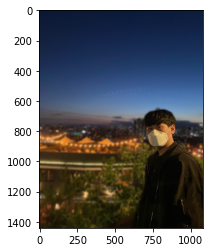

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

성공적으로 아웃포커싱 사진을 만들었습니다.

## 2. 고양이 아웃포커싱  
다음으로는 고양이 사진을 아웃포커싱 해보겠습니다. 전체적인 흐름은 같습니다.  
일단 사진을 불러옵시다.

(718, 960, 3)


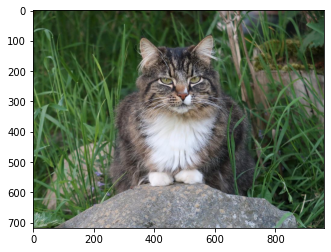

In [20]:
img2_path = '/content/drive/MyDrive/Colab/Datasets/segmentation/2.jpg'
img2_orig = cv2.imread(img2_path) 

print(img2_orig.shape)
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.show()

늠름한 자태입니다.  
아까 불러왔던 모델로 세그멘테이션을 해줍시다.

In [21]:
segvalues, output = model.segmentAsPascalvoc(img2_path)

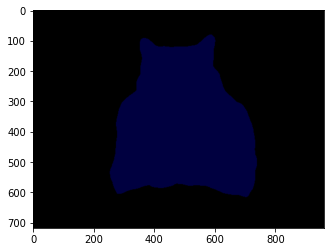

In [22]:
plt.imshow(output)
plt.show()

색깔이 비슷해서 잘 안보이지만, 파란색으로 고양이가 구분되었습니다.

고양이는 인덱스 8입니다. 컬러를 확인하고 mask를 만들어 줍시다.

In [23]:
print(LABEL_NAMES[8])
print(colormap[8])

cat
[64  0  0]


(718, 960)


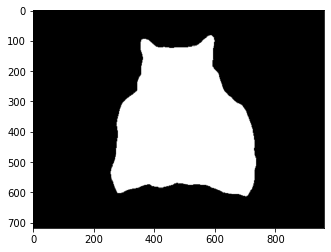

In [24]:
seg_color = (0, 0, 64)

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

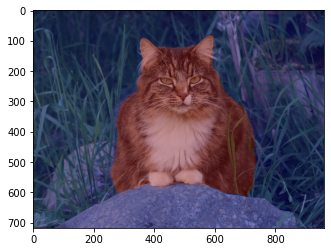

In [25]:
img2_show = img2_orig.copy()
img2_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img2_mask, cv2.COLORMAP_JET)
img2_show = cv2.addWeighted(img2_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))
plt.show()

성공적으로 고양이를 구분한 것 같습니다. 아까 셀카를 아웃포커싱 해줬을 때와 같은 동작을 수행해 줍시다.

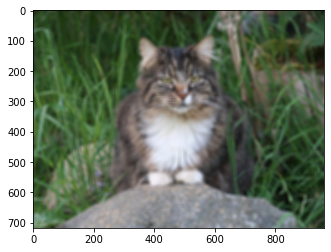

In [26]:
img2_orig_blur = cv2.blur(img2_orig, (13,13))  
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

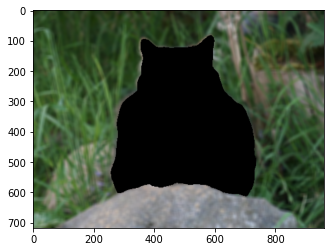

In [27]:
img2_mask_color = cv2.cvtColor(img2_mask, cv2.COLOR_GRAY2BGR)
img2_bg_mask = cv2.bitwise_not(img2_mask_color)
img2_bg_blur = cv2.bitwise_and(img2_orig_blur, img2_bg_mask)
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

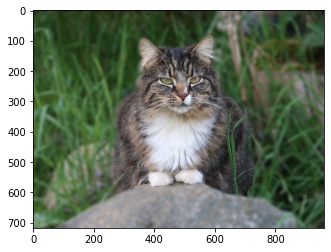

In [28]:
img2_concat = np.where(img2_mask_color==255, img2_orig, img2_bg_blur)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()

성공적으로 고양이만 선명한 사진이 나왔습니다.

## 3. 크로마키 배경 합성  
다음은 배경을 blur로 변경하는 것이 아닌 다른 사진으로 해서 크로마키 사진을 만들어 봅시다.  
일단 사진을 불러옵니다.

(1440, 1151, 3)


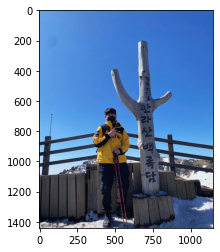

In [29]:
img3_path = '/content/drive/MyDrive/Colab/Datasets/segmentation/3.jpg'
img3_orig = cv2.imread(img3_path) 

print(img3_orig.shape)
plt.imshow(cv2.cvtColor(img3_orig, cv2.COLOR_BGR2RGB))
plt.show()

배경을 블러처리하기 전까지는 동일한 작업입니다. mask를 통해 사람부분만 빼올 수 있도록 세그멘테이션과 mask생성을 해줍니다.

In [30]:
segvalues, output = model.segmentAsPascalvoc(img3_path)

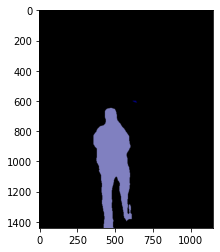

In [31]:
plt.imshow(output)
plt.show()

(1440, 1151)


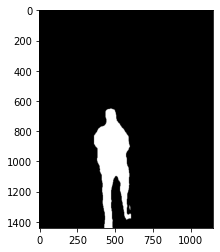

In [32]:
seg_color = (128,128,192)

seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

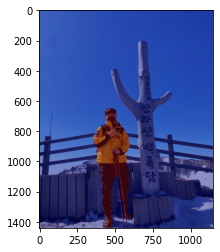

In [33]:
img3_show = img3_orig.copy()
img3_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img3_mask, cv2.COLORMAP_JET)
img3_show = cv2.addWeighted(img3_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img3_show, cv2.COLOR_BGR2RGB))
plt.show()

아까와는 달리 사람 부분의 마스크를 사용하도록 하겠습니다.

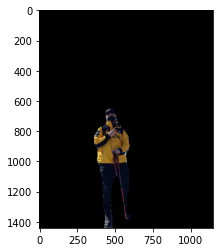

In [34]:
img3_mask_color = cv2.cvtColor(img3_mask, cv2.COLOR_GRAY2BGR)
img3_ps = cv2.bitwise_and(img3_orig, img3_mask_color)
plt.imshow(cv2.cvtColor(img3_ps, cv2.COLOR_BGR2RGB))
plt.show()

배경 이미지를 불러와서 mask를 이용해서 배경과 원본 사진을 합쳐줍시다.  
여기서 배경과 원본 사진의 크기를 맞추기 위해 원본 사진 크기로 불러온 배경사진을 resize 해주겠습니다.

In [35]:
img_path = '/content/drive/MyDrive/Colab/Datasets/segmentation/bg1.jpg'
img_back = cv2.imread(img_path)
img_back = cv2.resize(img_back, [img3_orig.shape[1], img3_orig.shape[0]]) 

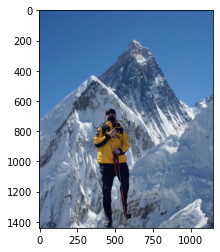

In [36]:
img3_concat1 = np.where(img3_mask_color==255, img3_ps, img_back)
plt.imshow(cv2.cvtColor(img3_concat1, cv2.COLOR_BGR2RGB))
plt.show()

성공적으로 크로마키 사진을 만들었습니다.  
다른 배경도 합쳐보겠습니다.

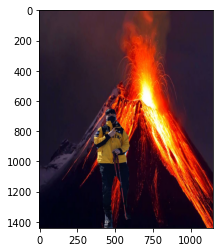

In [37]:
img_path = '/content/drive/MyDrive/Colab/Datasets/segmentation/bg2.jpg'
img_back = cv2.imread(img_path)
img_back = cv2.resize(img_back, [img3_orig.shape[1], img3_orig.shape[0]])
img3_concat2 = np.where(img3_mask_color==255, img3_ps, img_back)
plt.imshow(cv2.cvtColor(img3_concat2, cv2.COLOR_BGR2RGB))
plt.show()

많이 뜨겁겠네요

## 4. 문제점 및 해결 방법 생각해보기  
위의 사진들은 자세히 보면 문제점들이 있습니다. 세그멘테이션이 정확하게 모든 부분을 구분하지 못하기 때문에 크로마키 사진에서 다리가 조금 잘려 보인다거나 고양이 사진에서 털이 삐죽삐죽 튀어나와 있는 부분이나 고양이 앞에 있는 풀 부분이라거나 잘못된 부분이 존재합니다. 


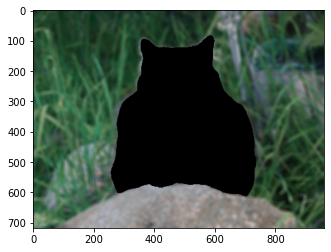

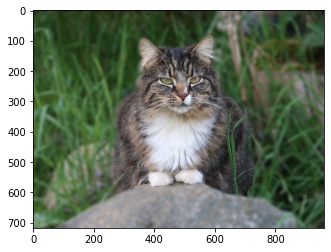

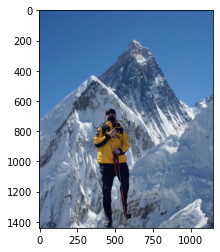

In [41]:
plt.imshow(img2_bg_blur)
plt.show()
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img3_concat1, cv2.COLOR_BGR2RGB))
plt.show()

이런 문제가 발생하는 이유는 세그멘테이션이 100%의 정확도로 작동하는것이 아니기 때문입니다.  
카메라의 아웃포커싱, 얕은 피사계 심도 촬영의 경우 일정 거리에 초점을 두기 때문에 정확하게 조절만 잘한다면 디테일한 부분을 모두 컨트롤 할 수 있겠지만, 여기서 사용된 방법은 단순히 배경만 블러처리하는 작업이었습니다.  
그렇다면 이러한 부분을 어떻게 개선할 수 있을지 한번 생각해 봅시다.

### 1. 이미지 전처리를 통한 세그멘테이션 성능 개선  
제가 처음으로 생각해 본 방법은 세그멘테이션의 성능을 개선하는 것입니다. 정확도가 100%가 되는것은 힘들겠지만 샤프닝을 통해 엣지를 강조한다던지, 명암대비를 조절하여 크로마키 사진과 같이 어두운 부분에서 모호해지는 경계를 명확히 한다던지 하는 방법도 있을 것입니다.

### 2. Depth 측정 활용 
다음으로 생각해 본 방법은 Depth를 측정하여 세그멘테이션에서 완전히 구분하지 못한 부분을 추가적으로 구분하는 것입니다.   
opencv에서 다른 각도에서 찍은 두 사진을 이용하여 depth를 측정하는 Stereo 기능이나 Struct 2 Depth 기능을 활용하여 고양이 사진과 같이 고양이로 구분된 세그멘테이션에서 더 가까운 부분에 있는 풀을 구분하여 추가적인 블러처리를 해줄 수 있다고 생각합니다.  
현재 구현된 기능을 보니 고양이의 털부분까지 해당 기능으로 구분하기는 어려울 것 같다고 생각하지만 풀 정도는 구분할 수 있을것으로 보입니다.

## 5. 회고
1. opencv의 stereo기능을 직접 사용해보고 싶었는데 사용하려니 계속 이미지에 정보가 부족하다고 뜨는데 스테레오 정보가 있는 이미지를 사용해야 한다고 한다. 그래서 블로그에서 예시로 사용한 사진이나 opencv 깃허브에서 사진을 다운받아서 해봤는데도 안되더라.. 
2. 고양이 세그멘테이션때 고양이의 삐죽삐죽 튀어나온 털을 구분하지 모한 부분은 거의 얼굴에서 귀쪽이던데 고양이 사진들을 보니 거의 그부분엔 털이 나와있지가 않더라. 털이 삐죽삐죽 튀어나온 고양이들로만 학습을 한다면 저것도 구분할 수 있을지 궁금하다.
3. 솔루션을 찾는다고 찾았는데 뭔가 시원한 답을 내릴수는 없었던 것 같아서 아쉽다.